# CycleGan

**dataset**
- https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/vangogh2photo.zip

**environment**
- python=3.6
- tensorflow=1.13.1
- scipy=1.2.1
- keras=2.2.4
- keras-contrib=2.0.8

## 结构简介
如果要用普通GAN将照片转换为绘画（或着反过来），需要使用成对的图像进行训练。而CycleGAN是一种特殊的GAN，无须使用成对图像进行训练，便可以将图像从一个领域 变换到另一个领域 。CycleGAN训练学习两种映射的生成网络。绝大多数GAN训练只一个生成网络，而CycleGAN会训练两个生成网络和两个判别网络。CycleGAN包含如下两个生成网络。
- 生成网络A：学习映射$G:X\rightarrow Y$，其中$X$是源领域， $Y$是目标领域。该映射接收源领域$A$的图像，将其转换成和目标领域$B$中的图像相似的图像。简单说来，该网络旨在学习能使$G(X)$和$Y$相似的映射。
- 生成网络B：学习映射$F:Y\rightarrow X$，接收目标领域$B$的图像，将其转换成和源领域$A$中图像相似的图像。类似地，该网络旨在学习能使$F(G(X))$和$X$相似的映射。

两个网络的架构相同，但都单独训练。

CycleGAN包含如下两个判别网络。
- 判别网络A：判别网络A负责区分生成网络B生成的图像（用$F(Y)$表示）和源领域A中的真实图像（表示为$X$）。
- 判别网络B：判别网络B负责区分生成网络A生成的图像（用$G(X) $表示）和目标领域B中的真实图像（表示为$Y$）。

两个网络的架构相同，也需要单独训练。

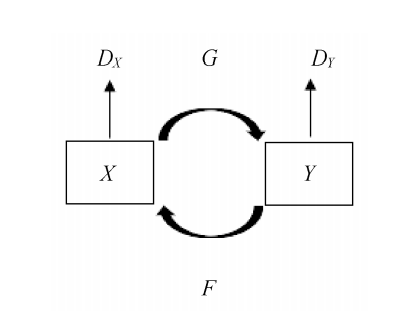

## 损失函数
### 总损失函数

$$L(G,F,D_x,D_y) = L_{GAN}(G,D_Y,X,Y)+L_{GAN}(F,D_X,Y,X)+\lambda L_{cyc}(G,F)$$

### 对抗损失
对抗损失是来自概率分布A或概率分布B的图像和生成网络生成的图像之间的损失。该网络涉及两个映射函数，都需要应用对抗损失。
$$L_{GAN}(G,D_Y,X,Y)=E_{y~p_{data}(y)}[logD_Y(y)]+E_{x~p_{data}(x)}[log(1-D_Y(G(x))]$$
**CycleGAN包含两个生成器G和F，对应两个判别器DX和DY，下面以生成器G和判别器DY进行分析（F和DX的原理与之相同）：**
- $G$输入$X$绘画，输出$G(X)$图片，使$D_Y$判断$G(X)$与$Y$越来越相似。
- $F$输入$Y$绘画，输出$F(Y)$图片，使$D_X$判断$F(Y)$与$X$越来越相似。

### 循环一致损失
对抗性损失能够让生成器$G$和生成器$F$学习到域$Y$和域$X$的分布，但是却没有保证从$X$得到$G(X)$时图像的内容不变，因为$G(X)$只需要符合域$Y$分布即可，并没有对其施加约束，所以$X$到$G(X)$包含很多种可能的映射。

利用循环一致性损失来进行约束，即$X$通过$G$生成$G(X)$后，再通过$F$，生成$F(G(X))$并使其接近于X。
$$L_{cyc}(G,F)=E_{x~p_{data}(x)}[||F(G(x))-x||_1]+E_{y~p_{data}(y)}[||G(F(y))-y||_1]$$

## 构建CycleGAN

In [1]:
# 导入需要的包
import time
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import Input, Model
from keras.callbacks import TensorBoard
from keras.layers import Conv2D, BatchNormalization, Activation, Add, Conv2DTranspose, \
    ZeroPadding2D, LeakyReLU
from keras.optimizers import Adam
from keras_contrib.layers import InstanceNormalization
from scipy.misc import imread, imresize

Using TensorFlow backend.


### 残差块

In [2]:
def residual_block(x):
    """
    Residual block
    """
    res = Conv2D(filters=128, kernel_size=3, strides=1, padding="same")(x)
    res = BatchNormalization(axis=3, momentum=0.9, epsilon=1e-5)(res)
    res = Activation('relu')(res)

    res = Conv2D(filters=128, kernel_size=3, strides=1, padding="same")(res)
    res = BatchNormalization(axis=3, momentum=0.9, epsilon=1e-5)(res)

    return Add()([res, x])

### 生成器

In [3]:
def build_generator():
    """
    Create a generator network using the hyperparameter values defined below
    """
    input_shape = (128, 128, 3)
    residual_blocks = 6
    input_layer = Input(shape=input_shape)

    # First Convolution block
    x = Conv2D(filters=32, kernel_size=7, strides=1, padding="same")(input_layer)
    x = InstanceNormalization(axis=1)(x)
    x = Activation("relu")(x)

    # 2nd Convolution block
    x = Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
    x = InstanceNormalization(axis=1)(x)
    x = Activation("relu")(x)

    # 3rd Convolution block
    x = Conv2D(filters=128, kernel_size=3, strides=2, padding="same")(x)
    x = InstanceNormalization(axis=1)(x)
    x = Activation("relu")(x)

    # Residual blocks
    for _ in range(residual_blocks):
        x = residual_block(x)

    # Upsampling blocks

    # 1st Upsampling block
    x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
    x = InstanceNormalization(axis=1)(x)
    x = Activation("relu")(x)

    # 2nd Upsampling block
    x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
    x = InstanceNormalization(axis=1)(x)
    x = Activation("relu")(x)

    # Last Convolution layer
    x = Conv2D(filters=3, kernel_size=7, strides=1, padding="same")(x)
    output = Activation('tanh')(x)

    model = Model(inputs=[input_layer], outputs=[output])
    return model

### 判别器

In [4]:
def build_discriminator():
    """
    Create a discriminator network using the hyperparameter values defined below
    """
    input_shape = (128, 128, 3)
    hidden_layers = 3

    input_layer = Input(shape=input_shape)

    x = ZeroPadding2D(padding=(1, 1))(input_layer)

    # 1st Convolutional block
    x = Conv2D(filters=64, kernel_size=4, strides=2, padding="valid")(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = ZeroPadding2D(padding=(1, 1))(x)

    # 3 Hidden Convolution blocks
    for i in range(1, hidden_layers + 1):
        x = Conv2D(filters=2 ** i * 64, kernel_size=4, strides=2, padding="valid")(x)
        x = InstanceNormalization(axis=1)(x)
        x = LeakyReLU(alpha=0.2)(x)

        x = ZeroPadding2D(padding=(1, 1))(x)

    # Last Convolution layer
    output = Conv2D(filters=1, kernel_size=4, strides=1, activation="sigmoid")(x)

    model = Model(inputs=[input_layer], outputs=[output])
    return model

### 载入图片

In [5]:
def load_images(data_dir):
    imagesA = glob(data_dir + '/testA/*.*')
    imagesB = glob(data_dir + '/testB/*.*')

    allImagesA = []
    allImagesB = []

    for index, filename in enumerate(imagesA):
        imgA = imread(filename, mode='RGB')
        imgB = imread(imagesB[index], mode='RGB')

        imgA = imresize(imgA, (128, 128))
        imgB = imresize(imgB, (128, 128))

        if np.random.random() > 0.5:
            imgA = np.fliplr(imgA)
            imgB = np.fliplr(imgB)

        allImagesA.append(imgA)
        allImagesB.append(imgB)

    # Normalize images
    allImagesA = np.array(allImagesA) / 127.5 - 1.
    allImagesB = np.array(allImagesB) / 127.5 - 1.

    return allImagesA, allImagesB


def load_test_batch(data_dir, batch_size):
    imagesA = glob(data_dir + '/testA/*.*')
    imagesB = glob(data_dir + '/testB/*.*')

    imagesA = np.random.choice(imagesA, batch_size)
    imagesB = np.random.choice(imagesB, batch_size)

    allA = []
    allB = []

    for i in range(len(imagesA)):
        # Load images and resize images
        imgA = imresize(imread(imagesA[i], mode='RGB').astype(np.float32), (128, 128))
        imgB = imresize(imread(imagesB[i], mode='RGB').astype(np.float32), (128, 128))

        allA.append(imgA)
        allB.append(imgB)

    return np.array(allA) / 127.5 - 1.0, np.array(allB) / 127.5 - 1.0


### 保存训练结果

In [6]:
def save_images(originalA, generatedB, recosntructedA, originalB, generatedA, reconstructedB, path):
    """
    Save images
    """
    fig = plt.figure()
    ax = fig.add_subplot(2, 3, 1)
    ax.imshow(originalA)
    ax.axis("off")
    ax.set_title("Original")

    ax = fig.add_subplot(2, 3, 2)
    ax.imshow(generatedB)
    ax.axis("off")
    ax.set_title("Generated")

    ax = fig.add_subplot(2, 3, 3)
    ax.imshow(recosntructedA)
    ax.axis("off")
    ax.set_title("Reconstructed")

    ax = fig.add_subplot(2, 3, 4)
    ax.imshow(originalB)
    ax.axis("off")
    ax.set_title("Original")

    ax = fig.add_subplot(2, 3, 5)
    ax.imshow(generatedA)
    ax.axis("off")
    ax.set_title("Generated")

    ax = fig.add_subplot(2, 3, 6)
    ax.imshow(reconstructedB)
    ax.axis("off")
    ax.set_title("Reconstructed")

    plt.savefig(path)


def write_log(callback, name, loss, batch_no):
    """
    Write training summary to TensorBoard
    """
    summary = tf.Summary()
    summary_value = summary.value.add()
    summary_value.simple_value = loss
    summary_value.tag = name
    callback.writer.add_summary(summary, batch_no)
    callback.writer.flush()

## 集成训练

D:\StudyApp\Anaconda\envs\learn\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
D:\StudyApp\Anaconda\envs\learn\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.
D:\StudyApp\Anaconda\envs\learn\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  if sys.path[0] == '':
D:\StudyApp\Anaconda\envs\learn\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0

Instructions for updating:
Colocations handled automatically by placer.
Epoch:0
Number of batches:100
Batch:0
Instructions for updating:
Use tf.cast instead.


D:\StudyApp\Anaconda\envs\learn\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


d_loss:[0.66408086 0.16836736]
g_loss:[12.273055, 1.6463543e-06, 2.4001005e-07, 0.53601074, 0.5796668, 0.52788275, 0.5883955]
Batch:1
d_loss:[0.4998476 0.5      ]
g_loss:[11.764106, 1.8138243e-07, 2.6108498e-08, 0.4919707, 0.57602525, 0.49830848, 0.58583856]
Batch:2
d_loss:[0.49986744 0.5       ]
g_loss:[11.784235, 2.1928761e-07, 1.0048799e-07, 0.46782213, 0.5972271, 0.5054271, 0.6283146]
Batch:3
d_loss:[0.49955422 0.5       ]
g_loss:[10.292703, 1.4471796e-06, 2.45603e-07, 0.5231544, 0.40109068, 0.5809519, 0.46929792]
Batch:4
d_loss:[0.4991543 0.5      ]
g_loss:[9.289468, 1.536196e-05, 1.0087822e-05, 0.41351843, 0.41379043, 0.4812429, 0.5351114]
Batch:5
d_loss:[0.4987448 0.5      ]
g_loss:[8.2746, 1.9982651e-06, 0.00032935268, 0.37175652, 0.36851004, 0.45202836, 0.41957462]
Batch:6
d_loss:[0.4978481 0.5      ]
g_loss:[9.944317, 2.912026e-06, 0.0016172933, 0.44525364, 0.45146585, 0.4522368, 0.5232649]
Batch:7
d_loss:[0.48055744 0.502551  ]
g_loss:[9.46916, 0.0016154106, 0.13259566, 0.47

D:\StudyApp\Anaconda\envs\learn\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
D:\StudyApp\Anaconda\envs\learn\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
D:\StudyApp\Anaconda\envs\learn\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
D:\StudyApp\Anaconda\envs\learn\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
Clipping input data to the valid ran

Epoch:1
Number of batches:100
Batch:0
d_loss:[0.23525386 0.5969388 ]
g_loss:[6.6409187, 0.36612016, 0.35822225, 0.2512585, 0.29102808, 0.22461492, 0.26909557]
Batch:1
d_loss:[0.2391926 0.5280612]
g_loss:[5.0020213, 0.33800435, 0.30914563, 0.21168253, 0.18560567, 0.20702657, 0.17496242]
Batch:2
d_loss:[0.20995595 0.61734694]
g_loss:[5.299326, 0.3042836, 0.42116284, 0.21793142, 0.19923887, 0.2233267, 0.1788502]
Batch:3
d_loss:[0.34306252 0.40816328]
g_loss:[5.699788, 0.2769373, 0.25998944, 0.25314856, 0.21907926, 0.24542257, 0.19516096]
Batch:4
d_loss:[0.21863526 0.60841835]
g_loss:[5.6690826, 0.3268088, 0.3333475, 0.24943058, 0.21188602, 0.19660226, 0.19915804]
Batch:5
d_loss:[0.23446862 0.56760204]
g_loss:[5.27592, 0.3442182, 0.32867754, 0.20588751, 0.21616843, 0.19897762, 0.1834874]
Batch:6
d_loss:[0.31905162 0.3864796 ]
g_loss:[6.1167245, 0.35686737, 0.26214308, 0.24340346, 0.2564697, 0.23640922, 0.26257327]
Batch:7
d_loss:[0.2569527  0.50765306]
g_loss:[5.743565, 0.30940413, 0.32206

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss:[5.3179264, 0.9109273, 0.9028615, 0.1589416, 0.15934348, 0.15199682, 0.16929005]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch:11
Number of batches:100
Batch:0
d_loss:[0.37341255 0.53826535]
g_loss:[4.1825213, 0.23742169, 0.40228862, 0.16137403, 0.16170749, 0.1599142, 0.15208161]
Batch:1
d_loss:[0.2435346  0.70408165]
g_loss:[4.912457, 0.2900565, 0.8906137, 0.19834802, 0.14186734, 0.17404841, 0.15558484]
Batch:2
d_loss:[0.19761343 0.7385204 ]
g_loss:[4.209812, 0.15904456, 0.8350784, 0.16952936, 0.12036933, 0.18669848, 0.13000417]
Batch:3
d_loss:[0.38677245 0.53571427]
g_loss:[4.609223, 0.04501761, 0.97170156, 0.19753812, 0.12652375, 0.208113, 0.14377174]
Batch:4
d_loss:[0.31627494 0.58673465]
g_loss:[3.844125, 0.18060018, 0.74543154, 0.14896873, 0.11469923, 0.1650103, 0.116403684]
Batch:5
d_loss:[0.3481345 0.5102041]
g_loss:[4.55163, 0.52939844, 0.6446661, 0.16685194, 0.13991383, 0.18099403, 0.12891404]
Batch:6
d_loss:[0.31327385 0.6122449 ]
g_loss:[5.2036767, 0.570233, 0.8216048, 0.18919343, 0.15369152, 0.21530218, 0.16768733]
Batch:7
d_loss:[0.2377289 0.6964286]
g_loss:[4.719946, 0.5001849, 0.8641734, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch:21
Number of batches:100
Batch:0
d_loss:[3.470688e-05 1.000000e+00]
g_loss:[2.254856, 6.435087e-05, 6.407479e-05, 0.1128263, 0.091516905, 0.10837653, 0.10291916]
Batch:1
d_loss:[2.652808e-05 1.000000e+00]
g_loss:[2.1654742, 0.00015346723, 0.00017718185, 0.11846312, 0.07740677, 0.12109311, 0.085351564]
Batch:2
d_loss:[5.0159422e-05 1.0000000e+00]
g_loss:[1.9283203, 4.0397186e-05, 4.010834e-05, 0.102306426, 0.07172148, 0.10436109, 0.08359967]
Batch:3
d_loss:[1.20801094e-04 1.00000000e+00]
g_loss:[2.0643759, 2.3218287e-05, 0.00011218877, 0.113349326, 0.073034406, 0.1081613, 0.09224185]
Batch:4
d_loss:[8.617366e-05 1.000000e+00]
g_loss:[2.0075994, 7.190384e-06, 0.02416779, 0.102672555, 0.077710144, 0.09663573, 0.08296169]
Batch:5
d_loss:[0.00134335 0.99872446]
g_loss:[2.0260615, 2.3957378e-05, 0.0036439155, 0.099405095, 0.08410089, 0.095860705, 0.09147301]
Batch:6
d_loss:[3.65772e-04 1.00000e+00]
g_loss:[2.1919248, 0.000530622, 0.0010811317, 0.100007296, 0.097247906, 0.11826387, 0.09

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch:31
Number of batches:100
Batch:0
d_loss:[3.122603e-05 1.000000e+00]
g_loss:[1.9269171, 1.3497456e-05, 4.836335e-05, 0.093505114, 0.08172919, 0.094493374, 0.08001879]
Batch:1
d_loss:[4.083052e-04 1.000000e+00]
g_loss:[1.9744773, 1.8920393e-05, 6.7742294e-05, 0.11100422, 0.06862459, 0.11250321, 0.06559931]
Batch:2
d_loss:[1.3424315e-04 1.0000000e+00]
g_loss:[1.741369, 1.5174042e-05, 2.8521177e-05, 0.08774769, 0.071449004, 0.08583723, 0.063521065]
Batch:3
d_loss:[9.5960844e-05 1.0000000e+00]
g_loss:[1.8721123, 2.3766124e-05, 0.0004175037, 0.101022765, 0.06934185, 0.09472686, 0.073297985]
Batch:4
d_loss:[7.86539e-04 1.00000e+00]
g_loss:[1.7761291, 9.889052e-06, 6.0474413e-05, 0.0851073, 0.077311896, 0.08426104, 0.06760577]
Batch:5
d_loss:[0.00102049 0.99872446]
g_loss:[1.7454185, 1.5295333e-05, 8.8642744e-05, 0.08536783, 0.07394284, 0.08034867, 0.07185908]
Batch:6
d_loss:[2.0547042e-04 1.0000000e+00]
g_loss:[1.9378463, 4.5161167e-05, 0.004839709, 0.096271545, 0.07978758, 0.092694245,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch:41
Number of batches:100
Batch:0
d_loss:[4.351166e-06 1.000000e+00]
g_loss:[1.9364607, 2.363894e-05, 2.5690559e-05, 0.09759317, 0.07966978, 0.08720962, 0.076572254]
Batch:1
d_loss:[5.18993e-06 1.00000e+00]
g_loss:[1.9032639, 0.0001625409, 1.8779396e-05, 0.0976487, 0.07572293, 0.099870935, 0.06949537]
Batch:2
d_loss:[1.6573003e-05 1.0000000e+00]
g_loss:[1.877794, 7.2848406e-06, 2.2544325e-05, 0.102352515, 0.07011087, 0.08993625, 0.063194126]
Batch:3
d_loss:[3.9316677e-05 1.0000000e+00]
g_loss:[1.8952116, 3.0711723e-05, 0.0006944462, 0.09880118, 0.07410522, 0.094172426, 0.071250014]
Batch:4
d_loss:[6.309958e-05 1.000000e+00]
g_loss:[1.766681, 1.4929301e-05, 0.00016340989, 0.09216245, 0.07065443, 0.07548619, 0.06284766]
Batch:5
d_loss:[6.915097e-05 1.000000e+00]
g_loss:[1.6632164, 0.00015037788, 1.5680158e-05, 0.07658473, 0.075652465, 0.07224417, 0.06843424]
Batch:6
d_loss:[2.8502487e-04 1.0000000e+00]
g_loss:[1.7330946, 0.0004444596, 0.001647095, 0.08586323, 0.07172872, 0.08585262,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch:51
Number of batches:100
Batch:0
d_loss:[1.2857716e-06 1.0000000e+00]
g_loss:[1.6710926, 0.00019578094, 1.6732876e-05, 0.08327049, 0.0691563, 0.08110635, 0.06550597]
Batch:1
d_loss:[2.3326727e-06 1.0000000e+00]
g_loss:[1.5951345, 0.0003299961, 1.4480794e-05, 0.091836736, 0.052958816, 0.09136115, 0.05547337]
Batch:2
d_loss:[3.937004e-06 1.000000e+00]
g_loss:[1.6133835, 2.5910056e-06, 8.39538e-06, 0.08353406, 0.0633457, 0.07866475, 0.065910086]
Batch:3
d_loss:[2.813318e-06 1.000000e+00]
g_loss:[1.5391376, 3.0581775e-06, 2.2821434e-05, 0.08605819, 0.053814173, 0.08318482, 0.057203174]
Batch:4
d_loss:[1.2531107e-05 1.0000000e+00]
g_loss:[1.5660727, 4.4478725e-07, 0.000576509, 0.0728324, 0.07098088, 0.069639295, 0.05772365]
Batch:5
d_loss:[7.0755614e-06 1.0000000e+00]
g_loss:[1.6237717, 5.921868e-05, 1.7035549e-05, 0.07588044, 0.07281539, 0.07048185, 0.06625524]
Batch:6
d_loss:[6.563975e-05 1.000000e+00]
g_loss:[1.6582521, 2.2390716e-06, 0.0010443453, 0.07405963, 0.075567275, 0.078156

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss:[1.5202152, 2.6997325e-06, 0.0045067705, 0.07860522, 0.05806135, 0.080024675, 0.0690153]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch:61
Number of batches:100
Batch:0
d_loss:[0.07823774 0.8890306 ]
g_loss:[1.5755627, 6.842343e-06, 0.00068578345, 0.07956826, 0.0636809, 0.08137577, 0.061002854]
Batch:1
d_loss:[0.08015656 0.8596939 ]
g_loss:[1.6700342, 0.00033086876, 0.0014745991, 0.08619316, 0.06541597, 0.10117061, 0.050966777]
Batch:2
d_loss:[0.01419421 0.99489796]
g_loss:[1.4938275, 3.1222542e-05, 0.0077260057, 0.07997188, 0.055437263, 0.07531972, 0.05665914]
Batch:3
d_loss:[0.02662204 0.9604592 ]
g_loss:[1.5624702, 1.9622552e-05, 0.08892564, 0.08135183, 0.051446162, 0.08363668, 0.06190838]
Batch:4
d_loss:[0.01452114 0.9846939 ]
g_loss:[1.599294, 3.160328e-07, 0.0022770911, 0.07379967, 0.068459004, 0.06520476, 0.109225035]
Batch:5
d_loss:[0.00666354 0.99872446]
g_loss:[1.5973371, 0.0012382476, 0.00042757852, 0.07647641, 0.06666968, 0.07130694, 0.0929035]
Batch:6
d_loss:[0.06260773 0.9005102 ]
g_loss:[1.5889493, 2.6358077e-05, 0.00021670944, 0.07805293, 0.06344063, 0.08074295, 0.093027696]
Batch:7
d_loss:[0.0317

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch:71
Number of batches:100
Batch:0
d_loss:[0.00354018 0.9961735 ]
g_loss:[1.5764964, 1.3262138e-06, 1.2436586e-05, 0.07698729, 0.067062676, 0.07599966, 0.059983432]
Batch:1
d_loss:[1.4177473e-04 1.0000000e+00]
g_loss:[1.4462548, 6.8596804e-05, 3.857503e-06, 0.084151134, 0.047233663, 0.085594326, 0.046740033]
Batch:2
d_loss:[3.410891e-05 1.000000e+00]
g_loss:[1.3370633, 3.1214165e-06, 1.4620265e-06, 0.071733385, 0.050407775, 0.068778805, 0.046868328]
Batch:3
d_loss:[2.5350575e-05 1.0000000e+00]
g_loss:[1.4930491, 1.0884847e-06, 5.127674e-06, 0.0820446, 0.05349839, 0.08392383, 0.053689253]
Batch:4
d_loss:[1.8695433e-04 1.0000000e+00]
g_loss:[1.3629061, 5.816957e-07, 4.613031e-06, 0.06825468, 0.05619742, 0.06238929, 0.05599069]
Batch:5
d_loss:[7.458147e-05 1.000000e+00]
g_loss:[1.3622651, 7.0765515e-07, 3.3925144e-06, 0.067301705, 0.056684982, 0.06390173, 0.05849232]
Batch:6
d_loss:[0.00926814 0.9859694 ]
g_loss:[1.5887917, 9.480072e-06, 1.0133133e-05, 0.07246108, 0.07121482, 0.076516

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss:[1.3370365, 0.0003052612, 8.933233e-06, 0.07062401, 0.050278015, 0.07028783, 0.05741428]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch:81
Number of batches:100
Batch:0
d_loss:[1.5189677e-06 1.0000000e+00]
g_loss:[1.4235965, 1.2966921e-05, 1.5457224e-06, 0.07253653, 0.05730202, 0.07090538, 0.054291286]
Batch:1
d_loss:[2.2864474e-06 1.0000000e+00]
g_loss:[1.3524461, 0.00043600626, 8.59073e-07, 0.07731766, 0.04538582, 0.08022483, 0.04474967]
Batch:2
d_loss:[5.2080386e-06 1.0000000e+00]
g_loss:[1.3119346, 5.0144004e-05, 1.2886654e-06, 0.070284754, 0.04975905, 0.06727463, 0.04417053]
Batch:3
d_loss:[2.3048108e-06 1.0000000e+00]
g_loss:[1.3346856, 2.3536328e-05, 4.6267863e-07, 0.07270552, 0.04861024, 0.072827175, 0.04867667]
Batch:4
d_loss:[3.770923e-05 1.000000e+00]
g_loss:[1.2553786, 8.45872e-08, 1.3697661e-05, 0.06068252, 0.053922594, 0.058136657, 0.051176917]
Batch:5
d_loss:[9.98328e-05 1.00000e+00]
g_loss:[1.3438239, 0.00014531924, 1.0736462e-06, 0.06358142, 0.059257936, 0.05961319, 0.05567071]
Batch:6
d_loss:[7.58356e-05 1.00000e+00]
g_loss:[1.4197332, 2.4141052e-06, 7.926585e-05, 0.06703094, 0.060950015, 0.0695

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss:[1.3960106, 1.7315563e-06, 3.544831e-05, 0.07361059, 0.053303342, 0.06957897, 0.057255115]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:91
Number of batches:100
Batch:0
d_loss:[5.8905944e-06 1.0000000e+00]
g_loss:[1.4349637, 3.365601e-07, 1.7450871e-05, 0.073067926, 0.058027446, 0.06962228, 0.0543699]
Batch:1
d_loss:[1.7511571e-05 1.0000000e+00]
g_loss:[1.325882, 1.1071444e-05, 9.231632e-07, 0.074606515, 0.04604538, 0.07760308, 0.04174791]
Batch:2
d_loss:[2.7942371e-05 1.0000000e+00]
g_loss:[1.2857441, 1.6517347e-07, 2.442483e-06, 0.06674671, 0.05088276, 0.06464356, 0.044803068]
Batch:3
d_loss:[4.563789e-05 1.000000e+00]
g_loss:[1.4009104, 1.876844e-07, 1.9519057e-05, 0.07587312, 0.051919855, 0.075414784, 0.047546085]
Batch:4
d_loss:[3.8758334e-04 1.0000000e+00]
g_loss:[1.2151456, 2.1005658e-08, 9.788354e-06, 0.059413984, 0.051711217, 0.057478584, 0.046405226]
Batch:5
d_loss:[1.3325973e-04 1.0000000e+00]
g_loss:[1.2492986, 1.2025497e-07, 3.434867e-06, 0.061333142, 0.052283406, 0.05960308, 0.053526424]
Batch:6
d_loss:[0.00774218 0.99107146]
g_loss:[1.2969583, 4.7078234e-07, 7.34398e-05, 0.0633991, 0.053090867, 0.0

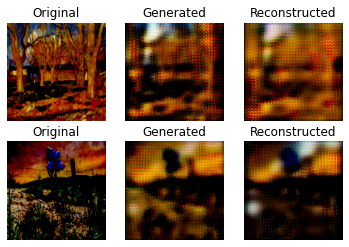

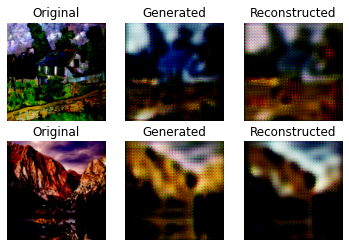

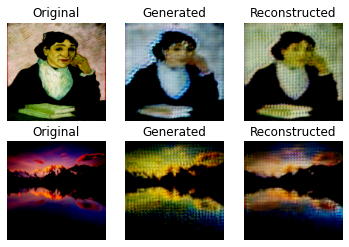

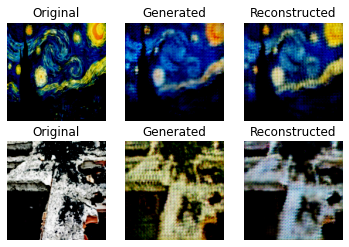

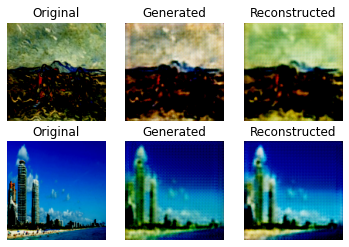

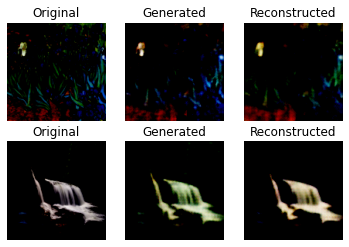

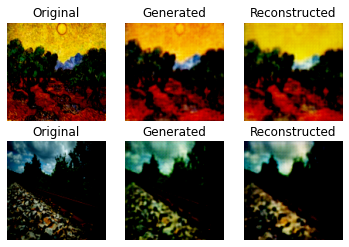

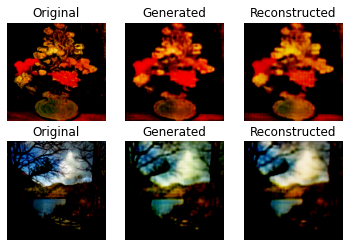

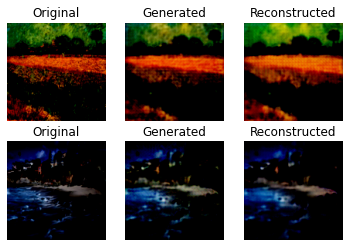

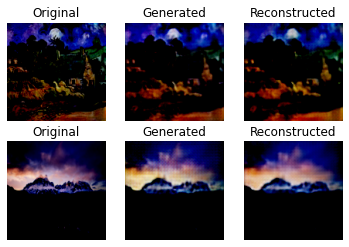

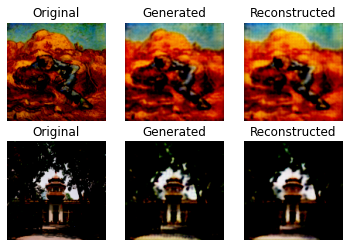

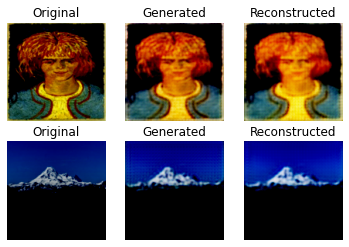

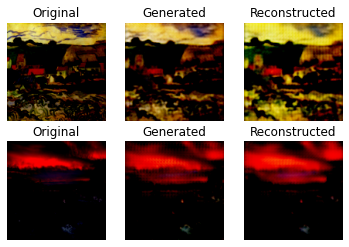

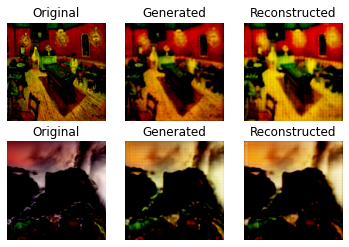

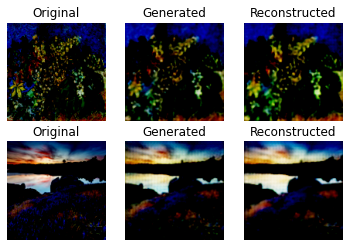

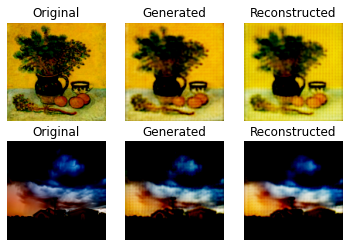

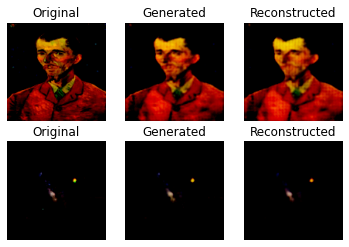

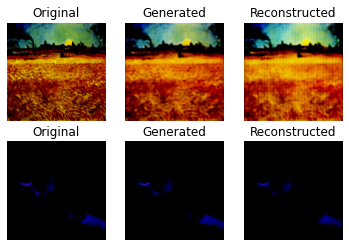

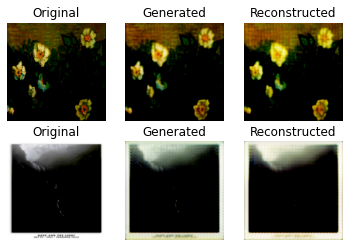

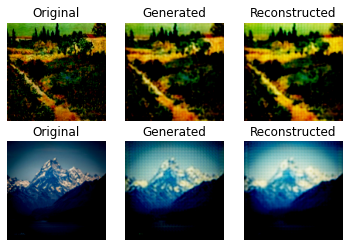

In [7]:
if __name__ == '__main__':
    data_dir = "../dataset/vangogh2photo/"
    batch_size = 4
    epochs = 100
    mode = 'train'

    if mode == 'train':
        # 载入数据
        imagesA, imagesB = load_images(data_dir=data_dir)

        # 迭代器设置
        common_optimizer = Adam(0.0002, 0.5)

        #定义网络，训练判别器
        discriminatorA = build_discriminator()
        discriminatorB = build_discriminator()

        discriminatorA.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])
        discriminatorB.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

        # 构建生成网络
        generatorAToB = build_generator()
        generatorBToA = build_generator()
        
        """
        创建对抗网络
        """
        inputA = Input(shape=(128, 128, 3))
        inputB = Input(shape=(128, 128, 3))

        # 构建两个生成器
        generatedB = generatorAToB(inputA)
        generatedA = generatorBToA(inputB)     
        
        # 构建重构网络
        reconstructedA = generatorBToA(generatedB)
        reconstructedB = generatorAToB(generatedA)
 
        generatedAId = generatorBToA(inputA)
        generatedBId = generatorAToB(inputB)

        # 使判别器不被训练
        discriminatorA.trainable = False
        discriminatorB.trainable = False
        

        probsA = discriminatorA(generatedA)
        probsB = discriminatorB(generatedB)

        # 整体网络构建
        adversarial_model = Model(inputs=[inputA, inputB],
                                  outputs=[probsA, probsB, reconstructedA, reconstructedB,
                                           generatedAId, generatedBId])
        adversarial_model.compile(loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'],
                                  loss_weights=[1, 1, 10.0, 10.0, 1.0, 1.0],
                                  optimizer=common_optimizer)
        # 利用tensorboard记录训练数据
        tensorboard = TensorBoard(log_dir="logs/{}".format(time.time()), write_images=True, write_grads=True,
                                  write_graph=True)
        tensorboard.set_model(generatorAToB)
        tensorboard.set_model(generatorBToA)
        tensorboard.set_model(discriminatorA)
        tensorboard.set_model(discriminatorB)

        real_labels = np.ones((batch_size, 7, 7, 1))
        fake_labels = np.zeros((batch_size, 7, 7, 1))

        for epoch in range(epochs):
            print("Epoch:{}".format(epoch))

            dis_losses = []
            gen_losses = []

            num_batches = int(min(imagesA.shape[0], imagesB.shape[0]) / batch_size)
            print("Number of batches:{}".format(num_batches))

            for index in range(num_batches):
                print("Batch:{}".format(index))

                # 获得样例图片
                batchA = imagesA[index * batch_size:(index + 1) * batch_size]
                batchB = imagesB[index * batch_size:(index + 1) * batch_size]

                # 利用生成器生成图片
                generatedB = generatorAToB.predict(batchA)
                generatedA = generatorBToA.predict(batchB)

                # 对判别器A训练区分真假图片
                dALoss1 = discriminatorA.train_on_batch(batchA, real_labels)
                dALoss2 = discriminatorA.train_on_batch(generatedA, fake_labels)

                # 对判别器B训练区分真假图片
                dBLoss1 = discriminatorB.train_on_batch(batchB, real_labels)
                dbLoss2 = discriminatorB.train_on_batch(generatedB, fake_labels)

                # 计算总的loss值
                d_loss = 0.5 * np.add(0.5 * np.add(dALoss1, dALoss2), 0.5 * np.add(dBLoss1, dbLoss2))

                print("d_loss:{}".format(d_loss))

                """
                训练生成网络
                """
                g_loss = adversarial_model.train_on_batch([batchA, batchB],
                                                          [real_labels, real_labels, batchA, batchB, batchA, batchB])

                print("g_loss:{}".format(g_loss))

                dis_losses.append(d_loss)
                gen_losses.append(g_loss)

            """
            每一次都保留loss值
            """
            write_log(tensorboard, 'discriminator_loss', np.mean(dis_losses), epoch)
            write_log(tensorboard, 'generator_loss', np.mean(gen_losses), epoch)

            # 每10个世代进行一次效果展示
            if epoch % 10 == 0:
                # 得到测试机图片A,B
                batchA, batchB = load_test_batch(data_dir=data_dir, batch_size=2)

                # 利用生成器生成图片
                generatedB = generatorAToB.predict(batchA)
                generatedA = generatorBToA.predict(batchB)

                # 的到重构图片
                reconsA = generatorBToA.predict(generatedB)
                reconsB = generatorAToB.predict(generatedA)

                # 保存原生图片，生成图片，重构图片
                for i in range(len(generatedA)):
                    save_images(originalA=batchA[i], generatedB=generatedB[i], recosntructedA=reconsA[i],
                                originalB=batchB[i], generatedA=generatedA[i], reconstructedB=reconsB[i],
                                path="results/gen_{}_{}".format(epoch, i))

        # 保存模型
        generatorAToB.save_weights("./weight/generatorAToB.h5")
        generatorBToA.save_weights("./weight/generatorBToA.h5")
        discriminatorA.save_weights("./weight/discriminatorA.h5")
        discriminatorB.save_weights("./weight/discriminatorB.h5")

    elif mode == 'predict':
        # 构建生成网络并载入权重
        generatorAToB = build_generator()
        generatorBToA = build_generator()

        generatorAToB.load_weights("./weight/generatorAToB.h5")
        generatorBToA.load_weights("./weight/generatorBToA.h5")

        # 获得预测的图片
        batchA, batchB = load_test_batch(data_dir=data_dir, batch_size=2)

        # 保存预测图片
        generatedB = generatorAToB.predict(batchA)
        generatedA = generatorBToA.predict(batchB)

        reconsA = generatorBToA.predict(generatedB)
        reconsB = generatorAToB.predict(generatedA)

        for i in range(len(generatedA)):
            save_images(originalA=batchA[i], generatedB=generatedB[i], recosntructedA=reconsA[i],
                        originalB=batchB[i], generatedA=generatedA[i], reconstructedB=reconsB[i],
                        path="results/test_{}".format(i))
